In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
# %pip install --upgrade pip
# %pip install --force-reinstall "ray[tune]" hyperopt


In [3]:
import sys
sys.path.insert(0, '../')  


In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
#from cvaei.models.cvae_inference import CVAE
from cvaei.examples.gk_dist import GKDistribution
from cvaei.models.multitask_cvae import MultiTaskCVAE


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [5]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = gk_dist.prepare_data(100000)
observed_data = gk_dist.observed_data()
gk_dist.check_normalizer()

Training Theta Shape: torch.Size([100000, 4])
Training Data Shape: torch.Size([100000, 1000])
Validation Theta Shape: torch.Size([10000, 4])
Validation Data Shape: torch.Size([10000, 1000])
Normalization and denormalization process is consistent for both parameters and observed data.


In [6]:
#gk_dist.get_info()
import ray
print(ray.__version__)


2.9.2


/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([100000, 4]), torch.Size([100000, 1000]))

# Initialise the Model

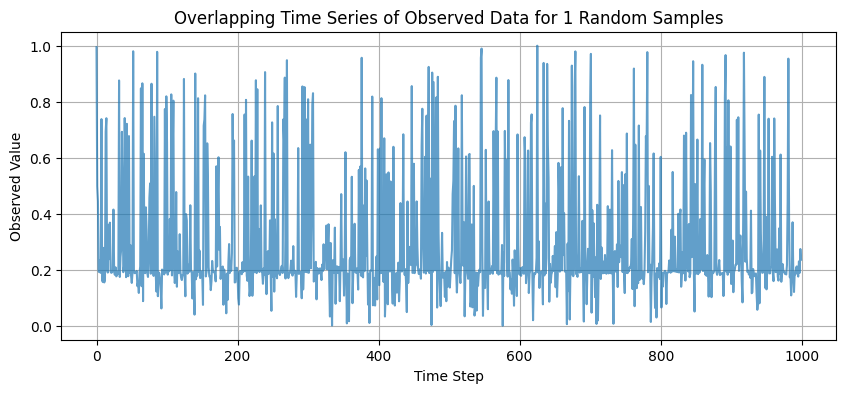

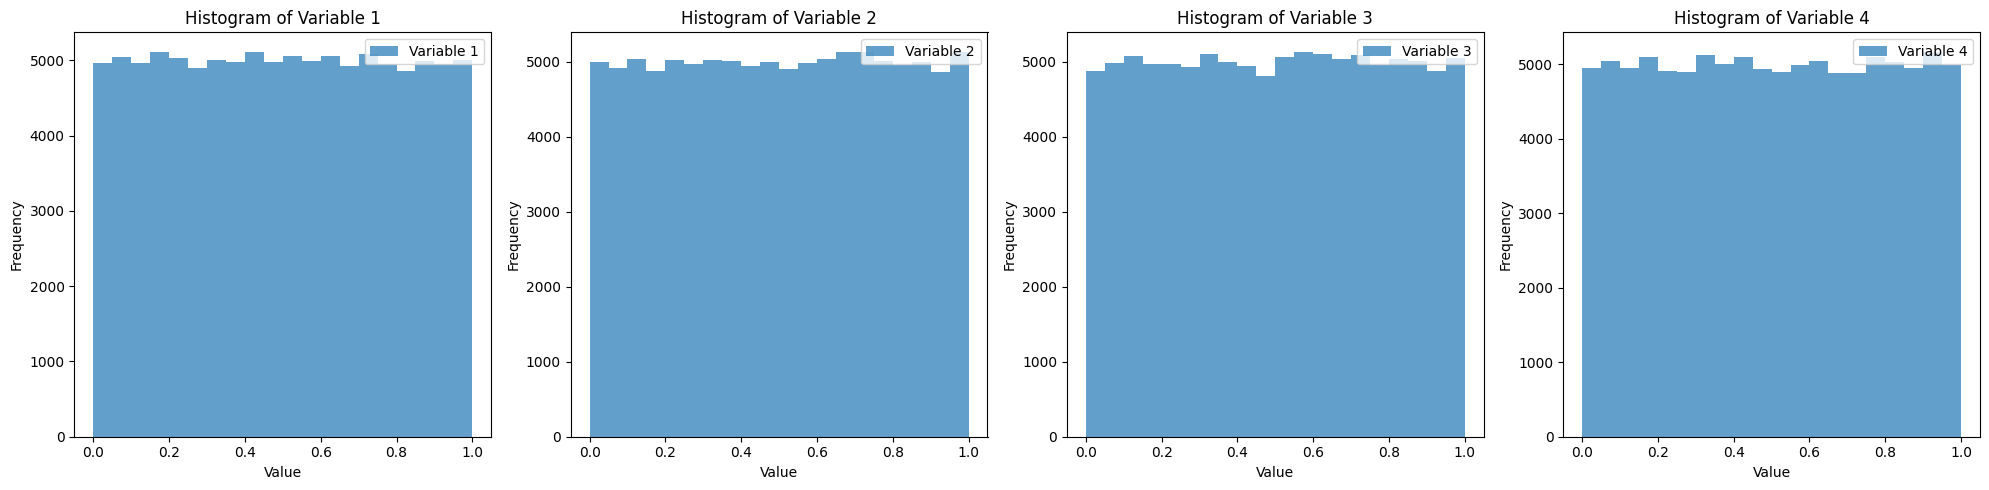

In [8]:
gk_dist.plot_observation(train_data_norm, num_samples =1)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [9]:
input_dim = 4
latent_dim = 16
conditional_dim = 1000
encoder_hidden_dims = [100,100]
decoder_hidden_dims = [2048,2048,2048]
activation_fn = nn.Sigmoid()

# network = CVAE(input_dim=input_dim, 
#                latent_dim=latent_dim, 
#                output_dim=input_dim,
#                 conditional_dim=conditional_dim,
#                 encoder_hidden_dims=encoder_hidden_dims,
#                 decoder_hidden_dims=decoder_hidden_dims,
#                 activation_fn = activation_fn,
#                 w_recon=1.0, 
#                 w_misfit=0.01,
# )

network = MultiTaskCVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=0.01)

optimizer = optim.AdamW(network.parameters(), lr=1e-5)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=512, shuffle=False)

# network.tune_model(train_loader = train_loader, 
#                 validation_loader = validation_loader,
#                 theta_normalizer=theta_normalizer,
#                 data_normalizer=data_normalizer,
#                 forward_model= gk_dist.simulator)

In [10]:
print(network)

MultiTaskCVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Sigmoid()
    )
    (fc_mean): Linear(in_features=100, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=100, out_features=16, bias=True)
  )
  (decoder): MultiTaskDecoder(
    (layers): Sequential(
      (0): Linear(in_features=1016, out_features=2048, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): Sigmoid()
    )
    (output_layer_1): Linear(in_features=2048, out_features=4, bias=True)
    (output_layer_2): Linear(in_features=2048, out_features=1000, bias=True)
  )
)


In [11]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    
                    patience=100)

Using CPU for training.
Epoch 1/20: Beta: 0.0, total_loss: 0.9500, recon_loss: 0.3552, misfit_loss: 0.5948, kl_div: 0.0000
Epoch 1/20 Validation: total_loss: 0.7509, recon_loss: 0.3317, misfit_loss: 0.4192, kl_div: 0.0000

Epoch 1: Validation loss improved to 0.00007509
Epoch 2/20: Beta: 0.1, total_loss: 0.7942, recon_loss: 0.3296, misfit_loss: 0.4194, kl_div: 0.0452
Epoch 2/20 Validation: total_loss: 0.7660, recon_loss: 0.3268, misfit_loss: 0.4192, kl_div: 0.0200

Epoch 2: No improvement in validation loss for 1 epochs.
Epoch 3/20: Beta: 0.2, total_loss: 0.7572, recon_loss: 0.3217, misfit_loss: 0.4194, kl_div: 0.0162
Epoch 3/20 Validation: total_loss: 0.7381, recon_loss: 0.3146, misfit_loss: 0.4192, kl_div: 0.0043

Epoch 3: Validation loss improved to 0.00007381
Epoch 4/20: Beta: 0.3, total_loss: 0.7231, recon_loss: 0.3019, misfit_loss: 0.4192, kl_div: 0.0020
Epoch 4/20 Validation: total_loss: 0.7062, recon_loss: 0.2871, misfit_loss: 0.4188, kl_div: 0.0003

Epoch 4: Validation loss im

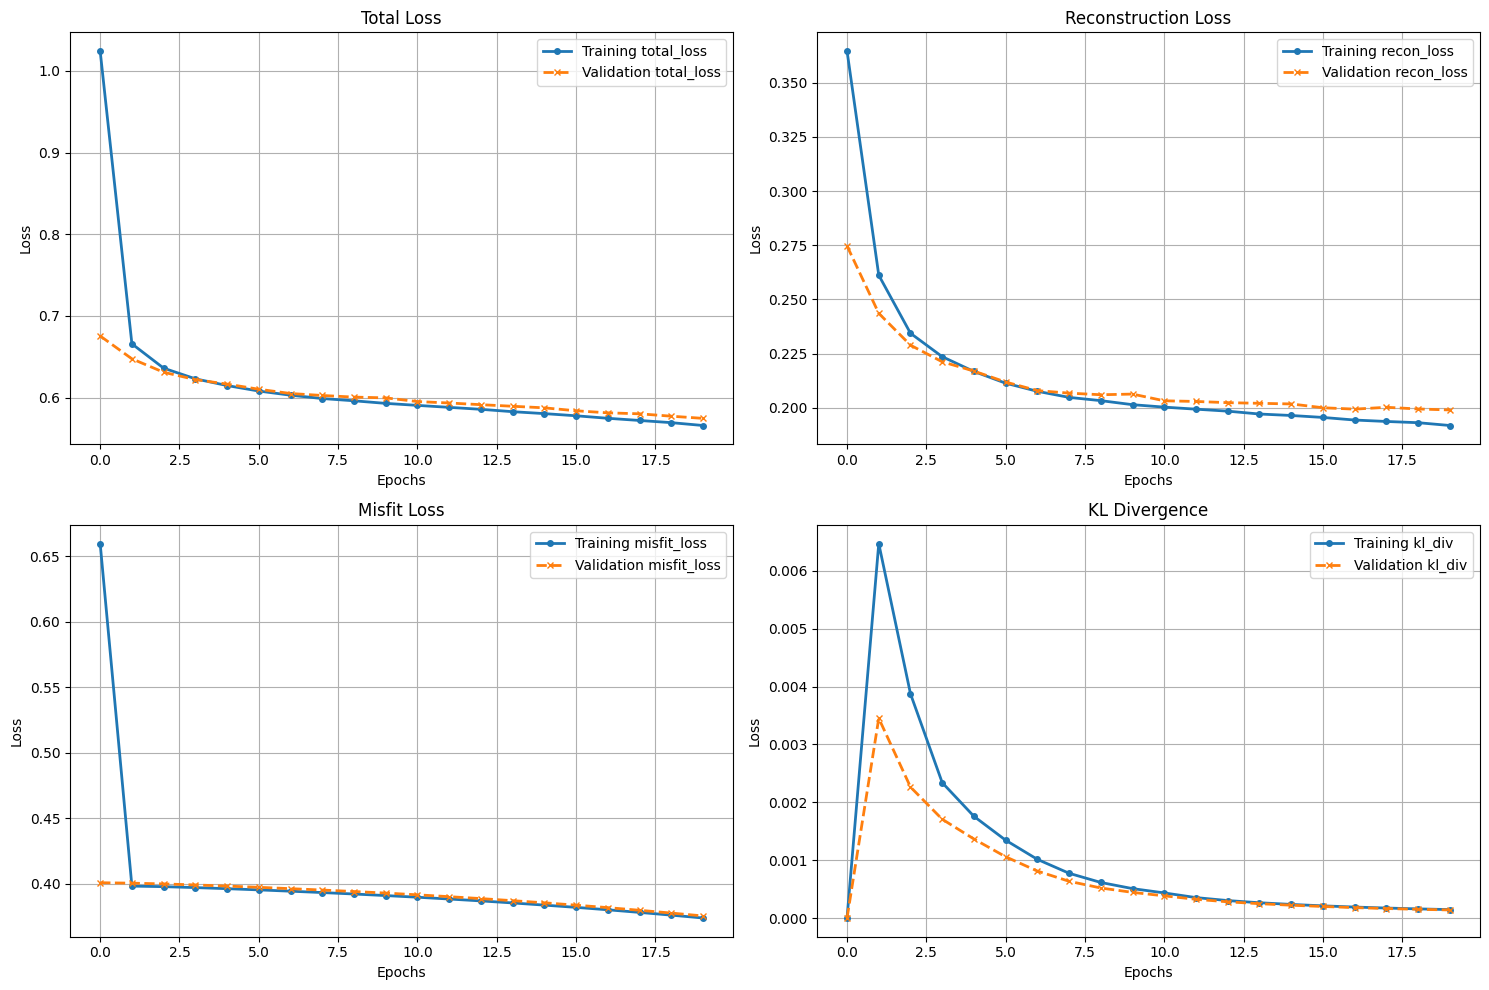

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


In [ ]:
#gk_dist.plot_posterior(post)

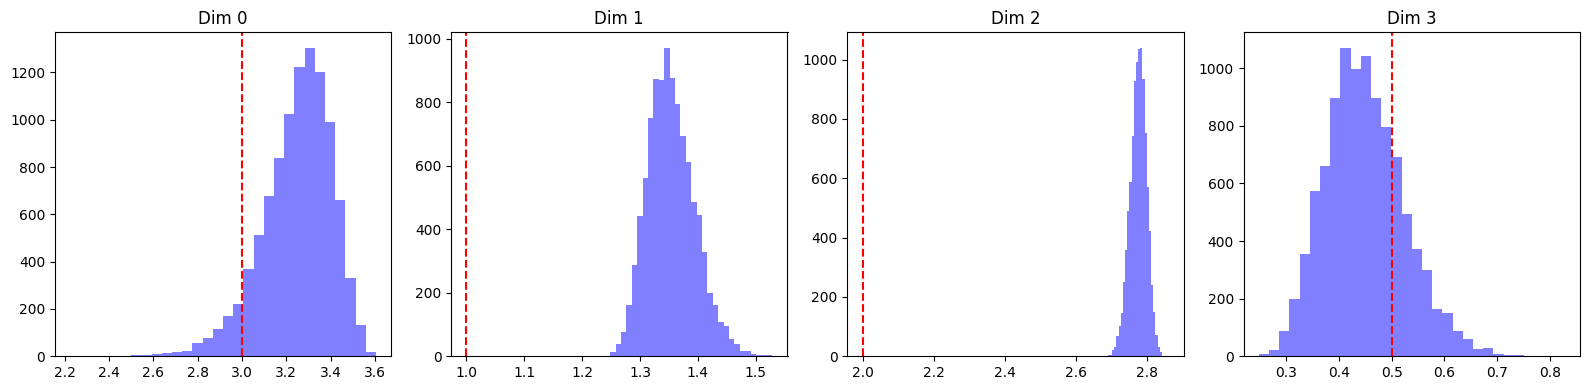

In [ ]:
gk_dist.posterior_hist(post)